/var/folders/8g/_dzxhc2n0gd7gd_s_lbkz36r0000gn/T/ipykernel_62794/2151942146.py:14: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', inplace=True)


Epoch 1/50, Loss: 0.024681
Epoch 2/50, Loss: 0.022624
Epoch 3/50, Loss: 0.022075
Epoch 4/50, Loss: 0.021900
Epoch 5/50, Loss: 0.021953
Epoch 6/50, Loss: 0.021658
Epoch 7/50, Loss: 0.021416
Epoch 8/50, Loss: 0.021259
Epoch 9/50, Loss: 0.021144
Epoch 10/50, Loss: 0.020956
Epoch 11/50, Loss: 0.020649
Epoch 12/50, Loss: 0.020423
Epoch 13/50, Loss: 0.020420
Epoch 14/50, Loss: 0.020048
Epoch 15/50, Loss: 0.019894
Epoch 16/50, Loss: 0.019571
Epoch 17/50, Loss: 0.019679
Epoch 18/50, Loss: 0.019452
Epoch 19/50, Loss: 0.019443
Epoch 20/50, Loss: 0.019155
Epoch 21/50, Loss: 0.018996
Epoch 22/50, Loss: 0.019013
Epoch 23/50, Loss: 0.018907
Epoch 24/50, Loss: 0.018664
Epoch 25/50, Loss: 0.018731
Epoch 26/50, Loss: 0.018620
Epoch 27/50, Loss: 0.018498
Epoch 28/50, Loss: 0.018320
Epoch 29/50, Loss: 0.018113
Epoch 30/50, Loss: 0.018186
Epoch 31/50, Loss: 0.018235
Epoch 32/50, Loss: 0.017875
Epoch 33/50, Loss: 0.017781
Epoch 34/50, Loss: 0.017744
Epoch 35/50, Loss: 0.017692
Epoch 36/50, Loss: 0.017669
E

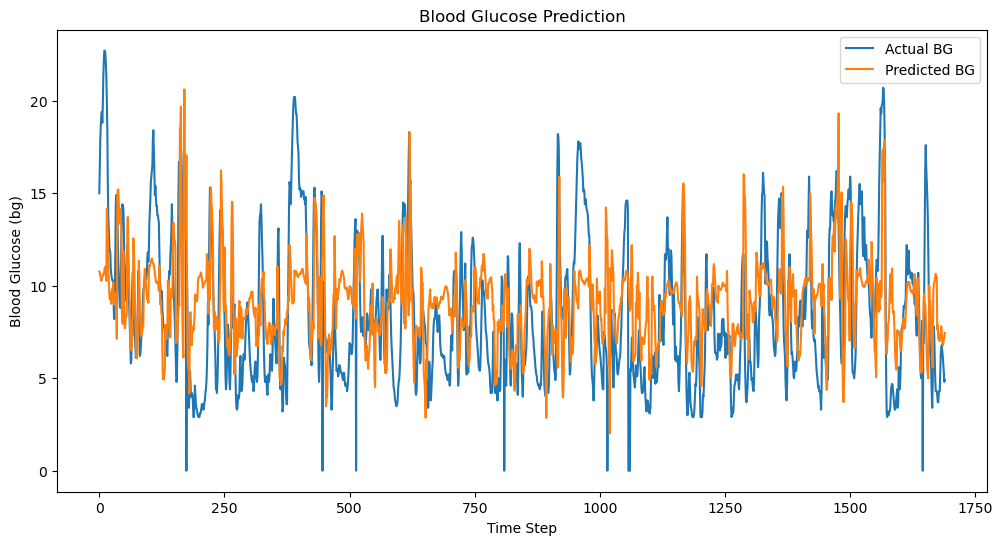

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 데이터 로드
df = pd.read_csv('/Users/jaehwayang/DSL/EDA/sep/by_patient/p01.csv')

# 결측치 처리 (선형 보간)
df.interpolate(method='linear', inplace=True)
df.dropna(inplace=True)

# Feature와 Target 나누기
features = df.drop(columns=['bg', 'p_num', 'time']).values
target = df['bg'].values.reshape(-1, 1)

# 데이터 정규화
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

features_scaled = scaler_X.fit_transform(features)
target_scaled = scaler_y.fit_transform(target)

# 시계열 데이터 생성 함수
def create_sequences(X, y, seq_length):
    xs, ys = [], []
    for i in range(len(X) - seq_length):
        x_seq = X[i:(i + seq_length)]
        y_seq = y[i + seq_length]
        xs.append(x_seq)
        ys.append(y_seq)
    return np.array(xs), np.array(ys)

seq_length = 10
X_seq, y_seq = create_sequences(features_scaled, target_scaled, seq_length)

# Train/Test 데이터 나누기
train_size = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

# 텐서 데이터셋 생성
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), 
                              torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), 
                             torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# LSTM 모델 설계
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train.shape[2]
hidden_size = 64
model = LSTMModel(input_size, hidden_size)

# 손실 함수 및 옵티마이저 설정
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 모델 훈련
epochs = 50
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.6f}')

# 예측 및 평가
model.eval()
with torch.no_grad():
    y_pred = model(torch.tensor(X_test, dtype=torch.float32)).numpy()

y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f'Test RMSE: {rmse:.3f}')

# 예측 결과 시각화
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual BG')
plt.plot(y_pred_inv, label='Predicted BG')
plt.title('Blood Glucose Prediction')
plt.xlabel('Time Step')
plt.ylabel('Blood Glucose (bg)')
plt.legend()
plt.show()

torch.save(model.state_dict(), 'weight.pth')

In [13]:
weights = model.lstm.state_dict()
weights.keys()

odict_keys(['weight_ih_l0', 'weight_hh_l0', 'bias_ih_l0', 'bias_hh_l0', 'weight_ih_l1', 'weight_hh_l1', 'bias_ih_l1', 'bias_hh_l1'])

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 데이터 로드
df = pd.read_csv('/Users/jaehwayang/DSL/EDA/sep/by_patient/p02.csv')

# 결측치 처리 (선형 보간)
df.interpolate(method='linear', inplace=True)
df.dropna(inplace=True)

# Feature와 Target 나누기
features = df.drop(columns=['bg', 'p_num', 'time']).values
target = df['bg'].values.reshape(-1, 1)

# 데이터 정규화
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

features_scaled = scaler_X.fit_transform(features)
target_scaled = scaler_y.fit_transform(target)

# 시계열 데이터 생성 함수
def create_sequences(X, y, seq_length):
    xs, ys = [], []
    for i in range(len(X) - seq_length):
        x_seq = X[i:(i + seq_length)]
        y_seq = y[i + seq_length]
        xs.append(x_seq)
        ys.append(y_seq)
    return np.array(xs), np.array(ys)

seq_length = 10
X_seq, y_seq = create_sequences(features_scaled, target_scaled, seq_length)

# Train/Test 데이터 나누기
train_size = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

# 텐서 데이터셋 생성
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), 
                              torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), 
                             torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# LSTM 모델 설계
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train.shape[2]
hidden_size = 64
model = LSTMModel(input_size, hidden_size)
weights = torch.load()

# 손실 함수 및 옵티마이저 설정
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 모델 훈련
epochs = 50
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.6f}')

# 예측 및 평가
model.eval()
with torch.no_grad():
    y_pred = model(torch.tensor(X_test, dtype=torch.float32)).numpy()

y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f'Test RMSE: {rmse:.3f}')

# 예측 결과 시각화
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual BG')
plt.plot(y_pred_inv, label='Predicted BG')
plt.title('Blood Glucose Prediction')
plt.xlabel('Time Step')
plt.ylabel('Blood Glucose (bg)')
plt.legend()
plt.show()


/var/folders/8g/_dzxhc2n0gd7gd_s_lbkz36r0000gn/T/ipykernel_61979/3798490962.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', inplace=True)


Epoch 1/50, Loss: 0.014563
Epoch 2/50, Loss: 0.012704
Epoch 3/50, Loss: 0.012009


KeyboardInterrupt: 

In [17]:
import pandas as pd
import statsmodels.api as sm

# 데이터 불러오기
df = pd.read_csv('/Users/jaehwayang/DSL/EDA/sep/by_patient/p01.csv')

# 결과 저장 리스트
results = []

# 반복: 15~120분 (lag=1~8 row)
for lag in range(1, 9):
    df_lagged = df.copy()

    # lag 변수 생성
    df_lagged["insulin_lag"] = df_lagged["insulin"].shift(lag)
    df_lagged["carbs_lag"] = df_lagged["carbs"].shift(lag)

    # Δhr 계산 (현재 hr - lag된 hr)
    df_lagged["hr_lag"] = df_lagged["hr"].shift(lag)
    df_lagged["delta_hr"] = df_lagged["hr"] - df_lagged["hr_lag"]

    # 교호작용 항: insulin × carbs
    df_lagged["insulin_x_carbs_lag"] = df_lagged["insulin_lag"] * df_lagged["carbs_lag"]

    # Δbg 계산
    df_lagged["bg_diff"] = df_lagged["bg"].diff()

    # 회귀에 사용할 변수
    predictors = ["insulin_lag", "carbs_lag", "delta_hr", "insulin_x_carbs_lag"]
    df_model = df_lagged[["bg_diff"] + predictors].dropna()

    if df_model.empty:
        continue

    # 회귀 모델 적합
    X = sm.add_constant(df_model[predictors])
    y = df_model["bg_diff"]
    model = sm.OLS(y, X).fit()

    # 결과 저장
    results.append({
        "lag_min": lag * 15,
        "R_squared": model.rsquared,
        "model_pval": model.f_pvalue,
        "insulin_coef": model.params.get("insulin_lag"),
        "insulin_pval": model.pvalues.get("insulin_lag"),
        "carbs_coef": model.params.get("carbs_lag"),
        "carbs_pval": model.pvalues.get("carbs_lag"),
        "delta_hr_coef": model.params.get("delta_hr"),
        "delta_hr_pval": model.pvalues.get("delta_hr"),
        "interaction_coef": model.params.get("insulin_x_carbs_lag"),
        "interaction_pval": model.pvalues.get("insulin_x_carbs_lag"),
    })

# 결과 출력
results_df = pd.DataFrame(results)
print(results_df.round(4))

   lag_min  R_squared  model_pval  insulin_coef  insulin_pval  carbs_coef  \
0       15     0.0043         0.0       -0.0440        0.0189      0.0204   
1       30     0.0076         0.0       -0.1154        0.0000      0.0048   
2       45     0.0190         0.0       -0.1987        0.0000     -0.0039   
3       60     0.0217         0.0       -0.1493        0.0000     -0.0175   
4       75     0.0175         0.0       -0.1596        0.0000     -0.0170   
5       90     0.0129         0.0       -0.1093        0.0000     -0.0197   
6      105     0.0069         0.0       -0.0783        0.0000     -0.0063   
7      120     0.0053         0.0       -0.0139        0.4594     -0.0085   

   carbs_pval  delta_hr_coef  delta_hr_pval  interaction_coef  \
0      0.0000         0.0019         0.1446           -0.0010   
1      0.2093        -0.0031         0.0034            0.0003   
2      0.3106        -0.0059         0.0000            0.0049   
3      0.0000        -0.0052         0.0000   

### Min-Max Scaling

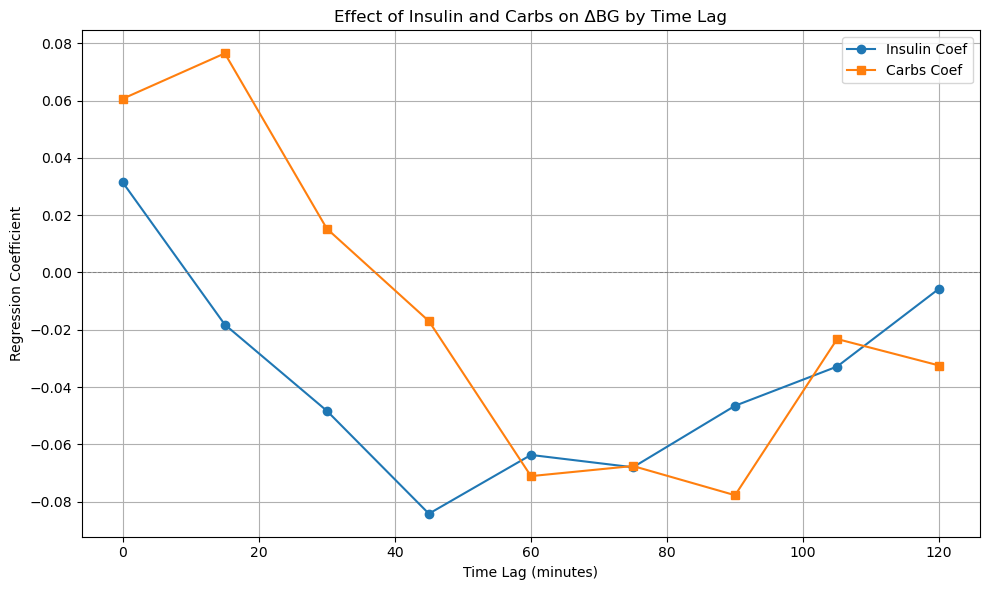


=== Regression Summary Table ===

   lag_min  R_squared  model_pval  insulin_coef  insulin_pval  carbs_coef  \
0        0     0.0104         0.0        0.0314        0.0001      0.0606   
1       15     0.0196         0.0       -0.0182        0.0208      0.0765   
2       30     0.0200         0.0       -0.0483        0.0000      0.0153   
3       45     0.0205         0.0       -0.0842        0.0000     -0.0170   
4       60     0.0237         0.0       -0.0637        0.0000     -0.0711   
5       75     0.0179         0.0       -0.0680        0.0000     -0.0676   
6       90     0.0134         0.0       -0.0465        0.0000     -0.0777   
7      105     0.0087         0.0       -0.0328        0.0000     -0.0232   
8      120     0.0062         0.0       -0.0056        0.4776     -0.0325   

   carbs_pval  
0      0.0001  
1      0.0000  
2      0.3110  
3      0.2607  
4      0.0000  
5      0.0000  
6      0.0000  
7      0.1259  
8      0.0327  


In [24]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 데이터 불러오기
df = pd.read_csv('/Users/jaehwayang/DSL/EDA/sep/by_patient/p01.csv')

# 정규화
scale_cols = ["insulin", "carbs", "hr", "steps", "cals", "bg"]
scaler = MinMaxScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])

# 결과 저장
results = []

# lag 반복 (0~8 → 0~120분)
for lag in range(0, 9):
    df_lagged = df.copy()

    for col in ["insulin", "carbs", "hr", "steps", "cals"]:
        df_lagged[f"{col}_lag"] = df_lagged[col].shift(lag)

    df_lagged["delta_hr"] = df_lagged["hr"] - df_lagged["hr_lag"]
    df_lagged["insulin_x_carbs_lag"] = df_lagged["insulin_lag"] * df_lagged["carbs_lag"]
    df_lagged["delta_hr_x_steps_lag"] = df_lagged["delta_hr"] * df_lagged["steps_lag"]
    df_lagged["bg_diff"] = df_lagged["bg"].diff()

    predictors = ["insulin_lag", "carbs_lag", "delta_hr", "steps_lag", "cals_lag",
                  "insulin_x_carbs_lag", "delta_hr_x_steps_lag"]
    df_model = df_lagged[["bg_diff"] + predictors].dropna()
    if df_model.empty:
        continue

    X = sm.add_constant(df_model[predictors])
    y = df_model["bg_diff"]
    model = sm.OLS(y, X).fit()

    results.append({
        "lag_min": lag * 15,
        "R_squared": model.rsquared,
        "model_pval": model.f_pvalue,
        "insulin_coef": model.params.get("insulin_lag"),
        "insulin_pval": model.pvalues.get("insulin_lag"),
        "carbs_coef": model.params.get("carbs_lag"),
        "carbs_pval": model.pvalues.get("carbs_lag")
    })

# 결과 DataFrame 생성
results_df = pd.DataFrame(results)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(results_df["lag_min"], results_df["insulin_coef"], marker='o', label='Insulin Coef')
plt.plot(results_df["lag_min"], results_df["carbs_coef"], marker='s', label='Carbs Coef')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
plt.title("Effect of Insulin and Carbs on ΔBG by Time Lag")
plt.xlabel("Time Lag (minutes)")
plt.ylabel("Regression Coefficient")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 통계 요약 출력
print("\n=== Regression Summary Table ===\n")
print(results_df[["lag_min", "R_squared", "model_pval", 
                  "insulin_coef", "insulin_pval", 
                  "carbs_coef", "carbs_pval"]].round(4))

### Z-score Scaling

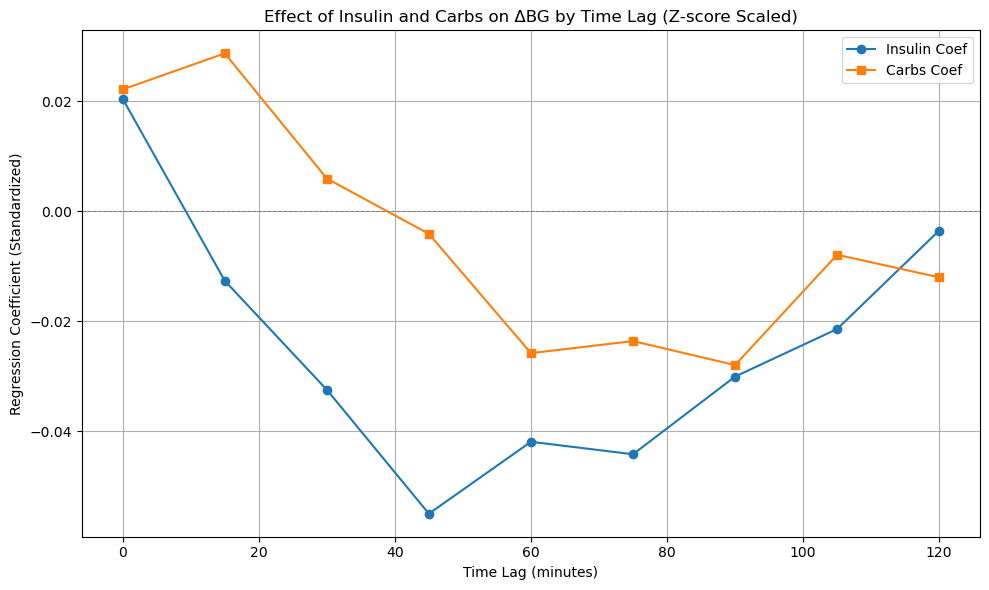


=== Regression Summary Table (Z-score Scaling) ===

   lag_min  R_squared  model_pval  insulin_coef  insulin_pval  carbs_coef  \
0        0     0.0104         0.0        0.0204        0.0001      0.0222   
1       15     0.0196         0.0       -0.0126        0.0144      0.0287   
2       30     0.0200         0.0       -0.0325        0.0000      0.0060   
3       45     0.0205         0.0       -0.0550        0.0000     -0.0041   
4       60     0.0237         0.0       -0.0419        0.0000     -0.0258   
5       75     0.0179         0.0       -0.0442        0.0000     -0.0236   
6       90     0.0134         0.0       -0.0301        0.0000     -0.0280   
7      105     0.0087         0.0       -0.0214        0.0000     -0.0079   
8      120     0.0062         0.0       -0.0035        0.5018     -0.0120   

   carbs_pval  
0      0.0001  
1      0.0000  
2      0.2829  
3      0.4595  
4      0.0000  
5      0.0000  
6      0.0000  
7      0.1568  
8      0.0316  


In [25]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 데이터 불러오기
df = pd.read_csv('/Users/jaehwayang/DSL/EDA/sep/by_patient/p01.csv')

# Z-score 정규화
scale_cols = ["insulin", "carbs", "hr", "steps", "cals", "bg"]
scaler = StandardScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])

# 결과 저장
results = []

# lag 반복 (0~8 → 0~120분)
for lag in range(0, 9):
    df_lagged = df.copy()

    for col in ["insulin", "carbs", "hr", "steps", "cals"]:
        df_lagged[f"{col}_lag"] = df_lagged[col].shift(lag)

    df_lagged["delta_hr"] = df_lagged["hr"] - df_lagged["hr_lag"]
    df_lagged["insulin_x_carbs_lag"] = df_lagged["insulin_lag"] * df_lagged["carbs_lag"]
    df_lagged["delta_hr_x_steps_lag"] = df_lagged["delta_hr"] * df_lagged["steps_lag"]
    df_lagged["bg_diff"] = df_lagged["bg"].diff()

    predictors = ["insulin_lag", "carbs_lag", "delta_hr", "steps_lag", "cals_lag",
                  "insulin_x_carbs_lag", "delta_hr_x_steps_lag"]
    df_model = df_lagged[["bg_diff"] + predictors].dropna()
    if df_model.empty:
        continue

    X = sm.add_constant(df_model[predictors])
    y = df_model["bg_diff"]
    model = sm.OLS(y, X).fit()

    results.append({
        "lag_min": lag * 15,
        "R_squared": model.rsquared,
        "model_pval": model.f_pvalue,
        "insulin_coef": model.params.get("insulin_lag"),
        "insulin_pval": model.pvalues.get("insulin_lag"),
        "carbs_coef": model.params.get("carbs_lag"),
        "carbs_pval": model.pvalues.get("carbs_lag")
    })

# 결과 DataFrame 생성
results_df = pd.DataFrame(results)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(results_df["lag_min"], results_df["insulin_coef"], marker='o', label='Insulin Coef')
plt.plot(results_df["lag_min"], results_df["carbs_coef"], marker='s', label='Carbs Coef')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
plt.title("Effect of Insulin and Carbs on ΔBG by Time Lag (Z-score Scaled)")
plt.xlabel("Time Lag (minutes)")
plt.ylabel("Regression Coefficient (Standardized)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 통계 요약 출력
print("\n=== Regression Summary Table (Z-score Scaling) ===\n")
print(results_df[["lag_min", "R_squared", "model_pval",
                  "insulin_coef", "insulin_pval",
                  "carbs_coef", "carbs_pval"]].round(4))

### Carbs 값이 있는 곳 앞뒤 120분씩만 활용

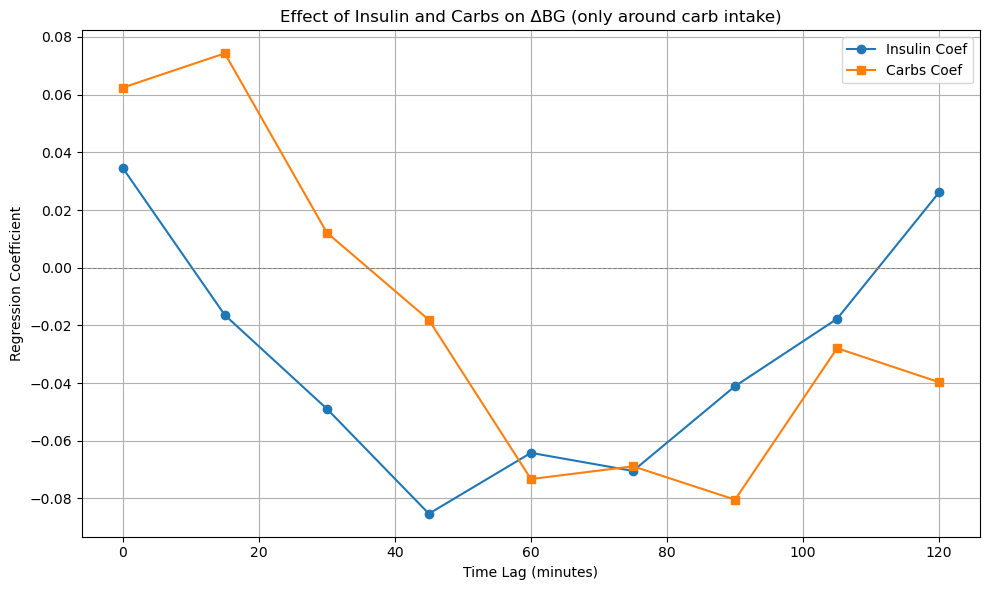


=== Regression Summary Table (carbs-centered ±120min) ===

   lag_min  R_squared  model_pval  insulin_coef  insulin_pval  carbs_coef  \
0        0     0.0105      0.0000        0.0346        0.0017      0.0624   
1       15     0.0205      0.0000       -0.0164        0.1340      0.0743   
2       30     0.0223      0.0000       -0.0489        0.0000      0.0122   
3       45     0.0215      0.0000       -0.0853        0.0000     -0.0181   
4       60     0.0232      0.0000       -0.0642        0.0000     -0.0733   
5       75     0.0189      0.0000       -0.0705        0.0000     -0.0689   
6       90     0.0137      0.0000       -0.0411        0.0002     -0.0804   
7      105     0.0058      0.0002       -0.0177        0.1085     -0.0279   
8      120     0.0055      0.0003        0.0261        0.0179     -0.0397   

   carbs_pval  
0      0.0019  
1      0.0002  
2      0.5423  
3      0.3646  
4      0.0002  
5      0.0006  
6      0.0001  
7      0.1654  
8      0.0486  


In [26]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 데이터 불러오기
df = pd.read_csv('/Users/jaehwayang/DSL/EDA/sep/by_patient/p01.csv')

# Min-Max Scaling
scale_cols = ["insulin", "carbs", "hr", "steps", "cals", "bg"]
scaler = MinMaxScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])

# carbs > 0인 시간 중심으로 앞뒤 120분씩 (1 row = 15분 → 8 rows씩 양옆)
rows_to_use = set()
for idx in df[df["carbs"] > 0].index:
    start = max(idx - 8, 0)
    end = min(idx + 8, len(df) - 1)
    rows_to_use.update(range(start, end + 1))

# 정렬 및 서브셋 생성
rows_to_use = sorted(rows_to_use)
df_subset = df.iloc[rows_to_use].copy()
df_subset.reset_index(drop=True, inplace=True)

# 결과 저장
results = []

# lag 0~8 (0~120분)
for lag in range(0, 9):
    df_lagged = df_subset.copy()

    for col in ["insulin", "carbs", "hr", "steps", "cals"]:
        df_lagged[f"{col}_lag"] = df_lagged[col].shift(lag)

    df_lagged["delta_hr"] = df_lagged["hr"] - df_lagged["hr_lag"]
    df_lagged["insulin_x_carbs_lag"] = df_lagged["insulin_lag"] * df_lagged["carbs_lag"]
    df_lagged["delta_hr_x_steps_lag"] = df_lagged["delta_hr"] * df_lagged["steps_lag"]
    df_lagged["bg_diff"] = df_lagged["bg"].diff()

    predictors = ["insulin_lag", "carbs_lag", "delta_hr", "steps_lag", "cals_lag",
                  "insulin_x_carbs_lag", "delta_hr_x_steps_lag"]
    df_model = df_lagged[["bg_diff"] + predictors].dropna()
    if df_model.empty:
        continue

    X = sm.add_constant(df_model[predictors])
    y = df_model["bg_diff"]
    model = sm.OLS(y, X).fit()

    results.append({
        "lag_min": lag * 15,
        "R_squared": model.rsquared,
        "model_pval": model.f_pvalue,
        "insulin_coef": model.params.get("insulin_lag"),
        "insulin_pval": model.pvalues.get("insulin_lag"),
        "carbs_coef": model.params.get("carbs_lag"),
        "carbs_pval": model.pvalues.get("carbs_lag")
    })

# 결과 테이블
results_df = pd.DataFrame(results)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(results_df["lag_min"], results_df["insulin_coef"], marker='o', label='Insulin Coef')
plt.plot(results_df["lag_min"], results_df["carbs_coef"], marker='s', label='Carbs Coef')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
plt.title("Effect of Insulin and Carbs on ΔBG (only around carb intake)")
plt.xlabel("Time Lag (minutes)")
plt.ylabel("Regression Coefficient")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 출력
print("\n=== Regression Summary Table (carbs-centered ±120min) ===\n")
print(results_df.round(4))

### 각 변수 별로 최적 lag를 구한 뒤, 그 lag를 적용시켜 구한 회귀 결과

In [21]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler

# 데이터 불러오기
df = pd.read_csv('/Users/jaehwayang/DSL/EDA/sep/by_patient/p01.csv')

# 정규화
scale_cols = ["insulin", "carbs", "hr", "steps", "cals", "bg"]
scaler = MinMaxScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])

# 최적 lag 지정
lags = {
    "insulin": 3,      # 45분
    "carbs": 1,        # 15분
    "steps": 1,        # 15분
    "cals": 2,         # 30분
    "hr": 3            # delta_hr at lag 45
}

# lagged 변수 생성
df_lagged = df.copy()
for var, lag in lags.items():
    df_lagged[f"{var}_lag"] = df_lagged[var].shift(lag)

# Δhr 계산
df_lagged["delta_hr"] = df_lagged["hr"] - df_lagged["hr_lag"]

# Δbg 계산
df_lagged["bg_diff"] = df_lagged["bg"].diff()

# interaction terms
df_lagged["insulin_x_carbs"] = df_lagged["insulin_lag"] * df_lagged["carbs_lag"]
df_lagged["delta_hr_x_steps"] = df_lagged["delta_hr"] * df_lagged["steps_lag"]

# 최종 모델 변수
predictors = ["insulin_lag", "carbs_lag", "delta_hr", "steps_lag", "cals_lag",
              "insulin_x_carbs", "delta_hr_x_steps"]

df_model = df_lagged[["bg_diff"] + predictors].dropna()
X = sm.add_constant(df_model[predictors])
y = df_model["bg_diff"]
model = sm.OLS(y, X).fit()

# 결과 출력
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                bg_diff   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     36.63
Date:                Sun, 03 Aug 2025   Prob (F-statistic):           7.44e-51
Time:                        12:46:05   Log-Likelihood:                 13063.
No. Observations:                8456   AIC:                        -2.611e+04
Df Residuals:                    8448   BIC:                        -2.605e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0006      0.001  

In [33]:
import os


paths = os.walk('/Users/jaehwayang/DSL/EDA/sep/by_patient')
for dir, _, path in paths:
    print(path)

['p10.csv', 'p04.csv', 'p05.csv', 'p11.csv', 'p12.csv', 'p06.csv', 'p02.csv', 'p03.csv', 'p01.csv']


### 모든 brist1d 데이터에 대한 그래프 그리기 및 결과 저장

In [42]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os
paths = os.walk('/Users/jaehwayang/DSL/EDA/sep/by_patient')
for dir, _, path in paths:
    print(dir, path)
file_paths = [os.path.join(dir, p) for p in path]

# 분석 반복
for file_path in file_paths:
    # 환자 ID 추출 (예: 'p01')
    patient_id = os.path.splitext(os.path.basename(file_path))[0]

    # 데이터 로딩 및 정규화
    df = pd.read_csv(file_path)
    scale_cols = ["insulin", "carbs", "hr", "steps", "cals", "bg"]
    scaler = MinMaxScaler()
    df[scale_cols] = scaler.fit_transform(df[scale_cols])

    results = []

    # lag 0~8 (0~120분)
    for lag in range(0, 9):
        df_lagged = df.copy()
        for col in ["insulin", "carbs", "hr", "steps", "cals"]:
            df_lagged[f"{col}_lag"] = df_lagged[col].shift(lag)

        df_lagged["delta_hr"] = df_lagged["hr"] - df_lagged["hr_lag"]
        df_lagged["insulin_x_carbs_lag"] = df_lagged["insulin_lag"] * df_lagged["carbs_lag"]
        df_lagged["delta_hr_x_steps_lag"] = df_lagged["delta_hr"] * df_lagged["steps_lag"]
        df_lagged["bg_diff"] = df_lagged["bg"].diff()

        predictors = ["insulin_lag", "carbs_lag", "delta_hr", "steps_lag", "cals_lag",
                      "insulin_x_carbs_lag", "delta_hr_x_steps_lag"]
        df_model = df_lagged[["bg_diff"] + predictors].dropna()
        if df_model.empty:
            continue

        X = sm.add_constant(df_model[predictors])
        y = df_model["bg_diff"]
        model = sm.OLS(y, X).fit()

        results.append({
            "lag_min": lag * 15,
            "R_squared": model.rsquared,
            "model_pval": model.f_pvalue,
            "insulin_coef": model.params.get("insulin_lag"),
            "insulin_pval": model.pvalues.get("insulin_lag"),
            "carbs_coef": model.params.get("carbs_lag"),
            "carbs_pval": model.pvalues.get("carbs_lag")
        })

    # 결과 DataFrame
    results_df = pd.DataFrame(results)

    # 그래프 저장
    plt.figure(figsize=(10, 6))
    plt.plot(results_df["lag_min"], results_df["insulin_coef"], marker='o', label='Insulin Coef')
    plt.plot(results_df["lag_min"], results_df["carbs_coef"], marker='s', label='Carbs Coef')
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
    plt.title(f"{patient_id}: Effect of Insulin and Carbs on ΔBG by Time Lag")
    plt.xlabel("Time Lag (minutes)")
    plt.ylabel("Regression Coefficient")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plot_path = f"{patient_id}_coef_plot.png"
    plt.savefig(plot_path)
    plt.close()

    # 결과 테이블 저장
    table_path = f"{patient_id}_regression_results.csv"
    results_df.to_csv(table_path, index=False)

    print(f"[{patient_id}] 저장 완료: {plot_path}, {table_path}")

/Users/jaehwayang/DSL/EDA/sep/by_patient ['p10.csv', 'p04.csv', 'p05.csv', 'p11.csv', 'p12.csv', 'p06.csv', 'p02.csv', 'p03.csv', 'p01.csv']
[p10] 저장 완료: p10_coef_plot.png, p10_regression_results.csv
[p04] 저장 완료: p04_coef_plot.png, p04_regression_results.csv
[p05] 저장 완료: p05_coef_plot.png, p05_regression_results.csv
[p11] 저장 완료: p11_coef_plot.png, p11_regression_results.csv
[p12] 저장 완료: p12_coef_plot.png, p12_regression_results.csv
[p06] 저장 완료: p06_coef_plot.png, p06_regression_results.csv
[p02] 저장 완료: p02_coef_plot.png, p02_regression_results.csv
[p03] 저장 완료: p03_coef_plot.png, p03_regression_results.csv
[p01] 저장 완료: p01_coef_plot.png, p01_regression_results.csv


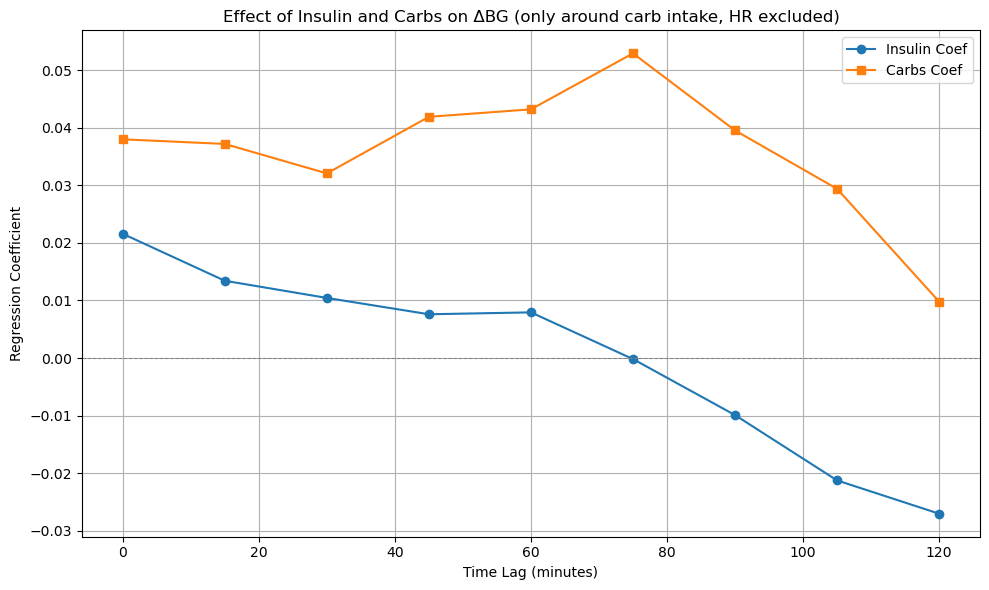


=== Regression Summary Table (carbs-centered ±120min, HR excluded) ===

   lag_min  R_squared  model_pval  insulin_coef  insulin_pval  carbs_coef  \
0        0     0.0038         0.0        0.0216        0.0000      0.0380   
1       15     0.0042         0.0        0.0134        0.0004      0.0372   
2       30     0.0023         0.0        0.0104        0.0055      0.0321   
3       45     0.0010         0.0        0.0076        0.0434      0.0419   
4       60     0.0010         0.0        0.0079        0.0351      0.0432   
5       75     0.0012         0.0       -0.0002        0.9609      0.0529   
6       90     0.0010         0.0       -0.0099        0.0084      0.0395   
7      105     0.0015         0.0       -0.0213        0.0000      0.0294   
8      120     0.0015         0.0       -0.0271        0.0000      0.0098   

   carbs_pval  
0      0.0000  
1      0.0001  
2      0.0006  
3      0.0000  
4      0.0000  
5      0.0000  
6      0.0000  
7      0.0016  
8      0.293

In [44]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 데이터 불러오기
df = pd.read_csv('/Users/jaehwayang/DSL/EDA/proc/cgm_final.csv')

# Min-Max Scaling
scale_cols = ["insulin", "carbs", "steps", "cals", "bg"]  # 'hr' 제거
scaler = MinMaxScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])

# carbs > 0인 시간 중심으로 앞뒤 120분씩 (1 row = 15분 → 8 rows씩 양옆)
rows_to_use = set()
for idx in df[df["carbs"] > 0].index:
    start = max(idx - 8, 0)
    end = min(idx + 8, len(df) - 1)
    rows_to_use.update(range(start, end + 1))

# 정렬 및 서브셋 생성
rows_to_use = sorted(rows_to_use)
df_subset = df.iloc[rows_to_use].copy()
df_subset.reset_index(drop=True, inplace=True)

# 결과 저장
results = []

# lag 0~8 (0~120분)
for lag in range(0, 9):
    df_lagged = df_subset.copy()

    for col in ["insulin", "carbs", "steps", "cals"]:  # 'hr' 제외
        df_lagged[f"{col}_lag"] = df_lagged[col].shift(lag)

    # 교호작용 항
    df_lagged["insulin_x_carbs_lag"] = df_lagged["insulin_lag"] * df_lagged["carbs_lag"]

    # Δbg 생성
    df_lagged["bg_diff"] = df_lagged["bg"].diff()

    predictors = ["insulin_lag", "carbs_lag", "steps_lag", "cals_lag", "insulin_x_carbs_lag"]
    df_model = df_lagged[["bg_diff"] + predictors].dropna()
    if df_model.empty:
        continue

    X = sm.add_constant(df_model[predictors])
    y = df_model["bg_diff"]
    model = sm.OLS(y, X).fit()

    results.append({
        "lag_min": lag * 15,
        "R_squared": model.rsquared,
        "model_pval": model.f_pvalue,
        "insulin_coef": model.params.get("insulin_lag"),
        "insulin_pval": model.pvalues.get("insulin_lag"),
        "carbs_coef": model.params.get("carbs_lag"),
        "carbs_pval": model.pvalues.get("carbs_lag")
    })

# 결과 테이블
results_df = pd.DataFrame(results)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(results_df["lag_min"], results_df["insulin_coef"], marker='o', label='Insulin Coef')
plt.plot(results_df["lag_min"], results_df["carbs_coef"], marker='s', label='Carbs Coef')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
plt.title("Effect of Insulin and Carbs on ΔBG (only around carb intake, HR excluded)")
plt.xlabel("Time Lag (minutes)")
plt.ylabel("Regression Coefficient")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 출력
print("\n=== Regression Summary Table (carbs-centered ±120min, HR excluded) ===\n")
print(results_df.round(4))

### Linear Mixture Model (LMM)

/var/folders/8g/_dzxhc2n0gd7gd_s_lbkz36r0000gn/T/ipykernel_65817/2148948610.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  t = pd.to_datetime(df[time_col], errors="coerce")


[lag= 0] n_obs=8458, n_groups=1
[lag= 1] n_obs=8458, n_groups=1
[lag= 2] n_obs=8457, n_groups=1
[lag= 3] n_obs=8456, n_groups=1
[lag= 4] n_obs=8455, n_groups=1
[lag= 5] n_obs=8454, n_groups=1
[lag= 6] n_obs=8453, n_groups=1
[lag= 7] n_obs=8452, n_groups=1
[lag= 8] n_obs=8451, n_groups=1


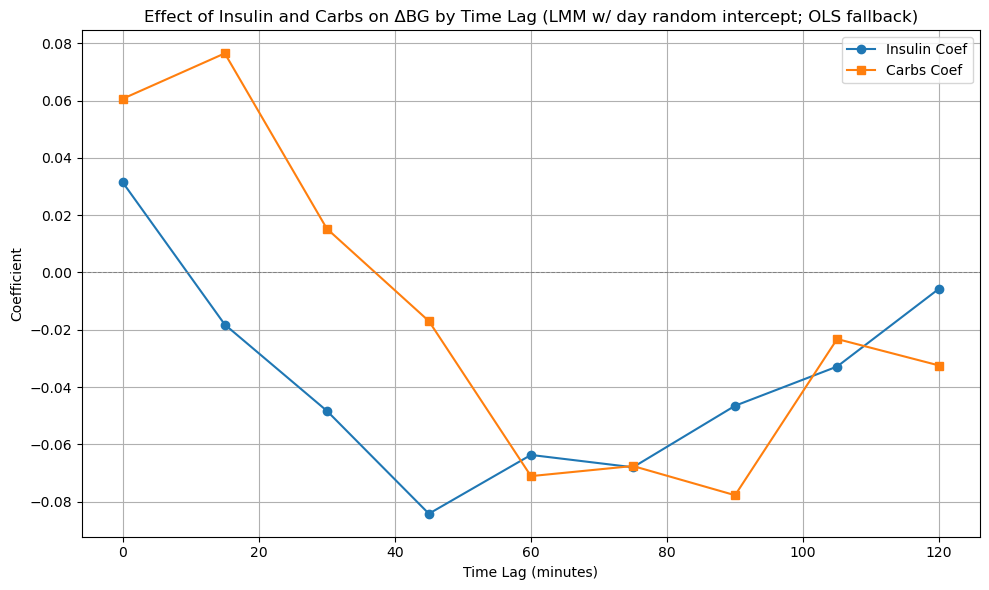


=== Regression Summary Table (by lag) ===

   lag_min          model  n_obs  n_groups         AIC         BIC  \
0        0  OLS(fallback)   8458         1 -25958.3902 -25916.1330   
1       15  OLS(fallback)   8458         1 -26033.0895 -25976.7465   
2       30  OLS(fallback)   8457         1 -26032.4088 -25976.0668   
3       45  OLS(fallback)   8456         1 -26033.3978 -25977.0567   
4       60  OLS(fallback)   8455         1 -26056.6489 -26000.3088   
5       75  OLS(fallback)   8454         1 -26002.5187 -25946.1795   
6       90  OLS(fallback)   8453         1 -25959.8564 -25903.5182   
7      105  OLS(fallback)   8452         1 -25919.4774 -25863.1401   
8      120  OLS(fallback)   8451         1 -25893.8372 -25837.5009   

   insulin_coef  insulin_pval  carbs_coef  carbs_pval  var_random_intercept  \
0        0.0314        0.0001      0.0606      0.0001                   NaN   
1       -0.0182        0.0208      0.0765      0.0000                   NaN   
2       -0.0483   

In [7]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ---- 0) 데이터 불러오기 ----
df = pd.read_csv('/Users/jaehwayang/DSL/EDA/proc/sep/by_patient/p01.csv')

# ---- 1) 정규화 ----
scale_cols = ["insulin", "carbs", "hr", "steps", "cals", "bg"]
scaler = MinMaxScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])

# ---- 2) 그룹(랜덤효과) 변수: 날짜(day) ----
time_candidates = ["timestamp", "time", "datetime", "date", "Datetime", "Time", "Date"]
time_col = next((c for c in time_candidates if c in df.columns), None)

if time_col is not None:
    t = pd.to_datetime(df[time_col], errors="coerce")
    df["_day"] = t.dt.floor("D")
else:
    # 타임스탬프가 없을 때: 15분 간격 가정(96개/일)
    df["_idx"] = np.arange(len(df))
    df["_day"] = (df["_idx"] // 96).astype(int)

# ---- 3) 함수: 한 래그 적합 (LMM 시도, 실패 시 OLS 폴백) ----
def fit_one_lag(df_base: pd.DataFrame, lag: int):
    d = df_base.copy()

    for col in ["insulin", "carbs", "hr", "steps", "cals"]:
        d[f"{col}_lag"] = d[col].shift(lag)

    d["delta_hr"] = d["hr"] - d["hr_lag"]
    d["insulin_x_carbs_lag"] = d["insulin_lag"] * d["carbs_lag"]
    d["delta_hr_x_steps_lag"] = d["delta_hr"] * d["steps_lag"]
    d["bg_diff"] = d["bg"].diff()

    predictors = [
        "insulin_lag", "carbs_lag", "delta_hr", "steps_lag", "cals_lag",
        "insulin_x_carbs_lag", "delta_hr_x_steps_lag"
    ]
    keep_cols = ["bg_diff", "_day"] + predictors
    dm = d[keep_cols].dropna()

    if dm.empty:
        print(f"[lag={lag:>2}] skip: no rows after dropna()")
        return None

    X = sm.add_constant(dm[predictors], has_constant="add")
    y = dm["bg_diff"].values
    groups = dm["_day"].values
    n_groups = int(dm["_day"].nunique())
    n_obs = int(len(dm))

    print(f"[lag={lag:>2}] n_obs={n_obs}, n_groups={n_groups}")

    # 기본 결과 dict (먼저 채워두면 예외시에도 반환됨)
    out = {
        "lag_min": lag * 15,
        "n_obs": n_obs,
        "n_groups": n_groups,
        "model": "LMM",        # 또는 'OLS(fallback)'
        "loglik": np.nan,
        "AIC": np.nan,
        "BIC": np.nan,
        "insulin_coef": np.nan,
        "insulin_pval": np.nan,
        "carbs_coef": np.nan,
        "carbs_pval": np.nan,
        "var_random_intercept": np.nan,
        "var_resid": np.nan,
    }

    # 3-1) LMM 시도 (그룹이 2개 이상일 때만 의미)
    if n_groups >= 2:
        try:
            m = sm.MixedLM(endog=y, exog=X, groups=groups, exog_re=None, missing="drop")
            fit = m.fit(reml=False, method="lbfgs", maxiter=200, disp=False)

            out.update({
                "model": "LMM",
                "loglik": fit.llf,
                "AIC": fit.aic,
                "BIC": fit.bic,
                "insulin_coef": float(fit.fe_params.get("insulin_lag", np.nan)),
                "insulin_pval":  float(fit.pvalues.get("insulin_lag", np.nan)),
                "carbs_coef":   float(fit.fe_params.get("carbs_lag", np.nan)),
                "carbs_pval":   float(fit.pvalues.get("carbs_lag", np.nan)),
                "var_random_intercept": float(fit.cov_re.iloc[0,0]) if getattr(fit, "cov_re", None) is not None and fit.cov_re.shape[0] > 0 else np.nan,
                "var_resid": float(fit.scale)
            })
            return out
        except Exception as e:
            print(f"[lag={lag:>2}] MixedLM failed -> fallback to OLS. reason={e}")

    # 3-2) OLS 폴백 (그룹이 1개뿐이거나 LMM 실패)
    try:
        ols_fit = sm.OLS(y, X).fit()
        out.update({
            "model": "OLS(fallback)",
            "AIC": ols_fit.aic,
            "BIC": ols_fit.bic,
            "insulin_coef": float(ols_fit.params.get("insulin_lag", np.nan)),
            "insulin_pval":  float(ols_fit.pvalues.get("insulin_lag", np.nan)),
            "carbs_coef":   float(ols_fit.params.get("carbs_lag", np.nan)),
            "carbs_pval":   float(ols_fit.pvalues.get("carbs_lag", np.nan)),
            "var_resid": float(ols_fit.scale)
        })
        return out
    except Exception as e2:
        print(f"[lag={lag:>2}] OLS fallback failed as well: {e2}")
        return None

# ---- 4) 래그 루프 실행 ----
results = []
for lag in range(0, 9):
    r = fit_one_lag(df, lag)
    if r is not None:
        results.append(r)

if not results:
    raise RuntimeError(
        "No models were fitted. "
        "가능한 원인: (1) 데이터가 매우 짧아 모든 래그에서 dropna 후 행이 0, "
        "(2) 컬럼명/타입 문제, (3) 하루 그룹 수가 항상 1개. "
        "타임스탬프/샘플 길이를 확인해 주세요."
    )

results_df = pd.DataFrame(results).sort_values("lag_min")

# ---- 5) 시각화: 인슐린/카브 계수 vs 래그 ----
plt.figure(figsize=(10, 6))
plt.plot(results_df["lag_min"], results_df["insulin_coef"], marker='o', label='Insulin Coef')
plt.plot(results_df["lag_min"], results_df["carbs_coef"], marker='s', label='Carbs Coef')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
plt.title("Effect of Insulin and Carbs on ΔBG by Time Lag (LMM w/ day random intercept; OLS fallback)")
plt.xlabel("Time Lag (minutes)")
plt.ylabel("Coefficient")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- 6) 요약표 출력 ----
cols_show = ["lag_min","model","n_obs","n_groups","AIC","BIC",
             "insulin_coef","insulin_pval","carbs_coef","carbs_pval",
             "var_random_intercept","var_resid"]
print("\n=== Regression Summary Table (by lag) ===\n")
print(results_df[cols_show].round(4))